# Well Decline Curve Fitting

First, let's import the necessary libraries

In [5]:
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
%matplotlib inline

Let's define three decline curve functions that we can pass into ``curve_fit``:
``exponential``, ``hyperbolic``, and ``harmonic``

**Exponential Decline**
$$q(\Delta t)=q_i e^{-a\Delta t}$$
where $q_i$ is the initial rate, and $a$ is the decline rate. The exponential decline curve has one fitting parameter: $a$

**Hyperbolic Decline**
$$q(\Delta t)=\frac{q_i}{(1+ba_i\Delta t)^{(\frac{1}{b})}}$$
where $q_i$ is the initial rate, and $a_i$ is the decline rate, $b$ fractional exponent. The hyperbolic decline curve has two fitting parameters: $a_i$ and $b$

**Harmonic Decline**
$$q(\Delta t)=\frac{q_i}{(1+a_i\Delta t)}$$
where $q_i$ is the initial rate, and $a_i$ is the decline rate. The harmonic decline curve has one fitting parameter: $a_i$

In [6]:
def decline_curve(curve_type, q_i):
    if curve_type == "exponential":
        def exponential_decline(T, a):
            return q_i*((np.exp(-a*T)))
        return exponential_decline
    
    elif curve_type == "hyperbolic":
        def hyperbolic_decline(T, a_i, b):
            return q_i/np.power((1+b*a_i*T), 1./b)
        return hyperbolic_decline
    
    elif curve_type == "harmonic":
        def parabolic_decline(T, a_i):
            return q_i/(1+a_i*T)
        return parabolic_decline
    
    else:
        raise "I don't know this decline curve!"

def L2_norm(pred, actual):
    return np.sum(np.power(np.subtract(pred, actual), 2))

# Production Estimation for a Single Well

In [8]:
df = pd.read_csv(r'well production.csv')
Q = df.loc[4][3:15] # oil prod
# Convert elements to floats
T = [float(x) for x in range(0, 12, 1)] # months: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
Q = [float(x) for x in Q]
df.head()

,Unnamed: 0,well name,average pressure (Pa),oil 1,oil 2,oil 3,oil 4,oil 5,oil 6,oil 7,oil 8,oil 9,oil 10,oil 11,oil 12,water 1,water 2,water 3,water 4,water 5,water 6,water 7,water 8,water 9,water 10,water 11,water 12
0,0,Tarragon 4-119H,26180969,10809.0,10108.0,9352.0,8626.0,7856.0,7137.0,6430.0,5678.0,4922.0,4205.0,3477.0,2724.0,1853.0,1720.0,1600.0,1481.0,1367.0,1237.0,1069.0,982.0,857.0,733.0,593.0,472.0
1,1,Fennel 10-129H,36433680,2049.0,1932.0,1784.0,1649.0,1499.0,1364.0,1226.0,1093.0,969.0,804.0,689.0,542.0,297.0,256.0,254.0,210.0,205.0,200.0,157.0,148.0,136.0,97.0,91.0,87.0
2,2,Federal 14-113H,36642888,11699.0,10905.0,10149.0,9365.0,8521.0,7732.0,6919.0,6124.0,5338.0,4536.0,3781.0,2954.0,827.0,762.0,720.0,661.0,617.0,541.0,466.0,435.0,394.0,340.0,266.0,213.0
3,3,King 7-184H,30429506,5980.0,5580.0,5176.0,4789.0,4405.0,3978.0,3581.0,3159.0,2735.0,2338.0,1914.0,1536.0,608.0,560.0,502.0,471.0,453.0,417.0,346.0,343.0,275.0,231.0,238.0,164.0
4,4,Sundae 1-129H,42591950,3892.0,3646.0,3399.0,3133.0,2834.0,2577.0,2309.0,2063.0,1800.0,1545.0,1279.0,1007.0,1247.0,1166.0,1096.0,974.0,902.0,806.0,790.0,668.0,570.0,468.0,394.0,322.0


Let's define our decline curves using our initial rate. We then pass these on to scipy.optimize.curve_fit and compute the L2 norm of the resulting fits (using the following equation): $$Error_{L2}=\sum{|{q(t)-q_{obs}(t)}|^2}$$

In [9]:
# Decline curve function (using initial rate)
exp_decline = decline_curve("exponential", Q[0])
hyp_decline = decline_curve("hyperbolic", Q[0])
har_decline = decline_curve("harmonic", Q[0])

# Store the optimized parameters for the fitted curves (T = time = x, Q = oil prod = y)
popt_exp, _ = curve_fit(exp_decline, T, Q, method="trf")
popt_hyp, _ = curve_fit(hyp_decline, T, Q, method="trf")
popt_har, _ = curve_fit(har_decline, T, Q, method="trf")

print("L2 Norm of exponential decline       : " + str(L2_norm(exp_decline(np.array(T), popt_exp[0]), Q)))
print("L2 Norm of hyperbolic decline: " + str(L2_norm(hyp_decline(np.array(T), popt_hyp[0], popt_hyp[1]), Q)))
print("L2 Norm of harmonic decline decline  : " + str(L2_norm(har_decline(np.array(T), popt_har[0]), Q)))

L2_norms = [L2_norm(exp_decline(np.array(T), popt_exp[0]), Q), L2_norm(hyp_decline(np.array(T), popt_hyp[0], popt_hyp[1]), Q), L2_norm(har_decline(np.array(T), popt_har[0]), Q)]
best_fit = L2_norms.index(min(L2_norms))

L2 Norm of exponential decline       : 349578.4953459189
L2 Norm of hyperbolic decline: 2210.868949459795
L2 Norm of harmonic decline decline  : 980022.8883363877


As we can see the hyperbolic decline fits the data much better than the other decline curves. Let's now visualise the results using matplotlib.

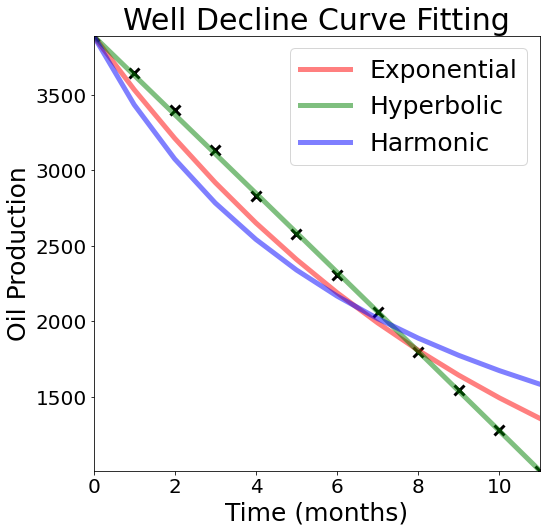

In [10]:
fig, ax = plt.subplots(1, figsize=(8, 8))

ax.set_title("Well Decline Curve Fitting", fontsize=30)

# Set size of tick labels
label_size = 20
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T))

# Plot actual datapoints
ax.scatter(T, Q, color="black", marker="x", s=100, linewidth=3)

# Axis labels
ax.set_xlabel("Time (months)", fontsize=25)
ax.set_ylabel("Oil Production", fontsize=25)

# Define the three prediction curves
pred_exp = exp_decline(np.array(T), popt_exp[0]).tolist()
pred_hyp = hyp_decline(np.array(T), popt_hyp[0], popt_hyp[1]).tolist()
pred_har = har_decline(np.array(T), popt_har[0]).tolist()

# Calculate min and max value for y-axis limits
min_val = min([min(curve) for curve in [pred_exp, pred_hyp, pred_har]])
max_val = max([max(curve) for curve in [pred_exp, pred_hyp, pred_har]])
ax.set_ylim(min_val, max_val)

# Plot the data
ax.plot(T, pred_exp, color="red", linewidth=5, alpha=0.5, label="Exponential")
ax.plot(T, pred_hyp, color="green", linewidth=5, alpha=0.5, label="Hyperbolic")
ax.plot(T, pred_har, color="blue", linewidth=5, alpha=0.5, label="Harmonic")

ax.legend(fontsize=25)

Let's also visualize production predictions for the three curves over the next 36 months

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


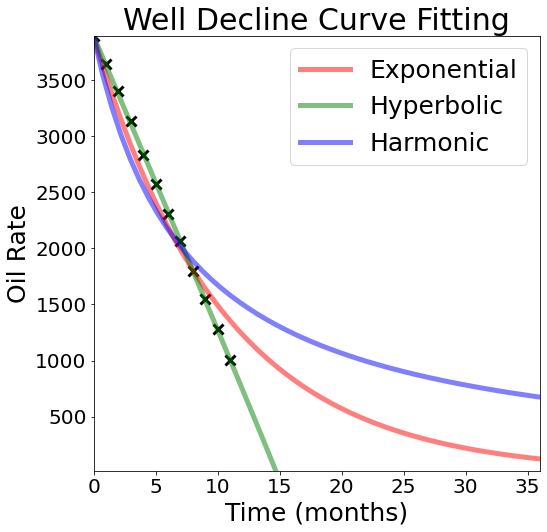

In [11]:
fig, ax = plt.subplots(1, figsize=(8, 8))

# Number of months for prediction
T_max = 36.0
T_pred = np.linspace(min(T), T_max)

ax.set_title("Well Decline Curve Fitting", fontsize=30)

# Set size of tick labels
label_size = 20
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T_pred))

# Plot actual datapoints
ax.scatter(T, Q, color="black", marker="x", s=100, linewidth=3)
ax.set_xlabel("Time (months)", fontsize=25)
ax.set_ylabel("Oil Rate", fontsize=25)

# Define the three prediction curves
pred_exp = exp_decline(T_pred, popt_exp[0])
pred_hyp = hyp_decline(T_pred, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T_pred, popt_har[0])

# Calculate min and max value for y-axis limits
min_val = min([min(curve) for curve in [pred_exp, pred_hyp, pred_har]])
max_val = max([max(curve) for curve in [pred_exp, pred_hyp, pred_har]])
ax.set_ylim(min_val, max_val)

# Plot the data
ax.plot(T_pred, pred_exp, color="red", linewidth=5, alpha=0.5, label="Exponential")
ax.plot(T_pred, pred_hyp, color="green", linewidth=5, alpha=0.5, label="Hyperbolic")
ax.plot(T_pred, pred_har, color="blue", linewidth=5, alpha=0.5, label="Harmonic")
ax.legend(fontsize=25)

In [12]:
# Store the prediction curves
pred_curves = [pred_exp, pred_hyp, pred_har]

# Oil threshold - monthly production at which drilling is no longer viable
oil_threshold = 35

# Estimate cumulative oil production (until oil threshold is reached)
last_month = next(month for month, pred_oil in enumerate(pred_curves[best_fit]) if pred_oil < oil_threshold or math.isnan(pred_oil)) - 1 # This is the last month oil drilling is profitable

# Print cumulative production estimate for the optimally fitted curve
curve_fit_names = ['exponential', 'hyperbolic', 'harmonic']
print('Cumulative production estimate ' + 'using a(n) ' + curve_fit_names[best_fit] + ' decline curve over ' + str(last_month) + ' months: ' + str(np.sum(pred_curves[best_fit][0:last_month+1]))) # Left Riemann sum to estimate integral of optimally fitted production curve

Cumulative production estimate using a(n) hyperbolic decline curve over 19 months: 41288.07601336715


# Production Estimation and Proppant/Pump Averaging for all Wells

In [38]:
df = pd.read_csv(r'well production.csv')
map = {}

well_names = []
well_productions = []

for i in range(0, len(df)):
    Q = df.loc[i][3:15] # oil prod
    # Convert elements to floats
    T = [float(x) for x in range(0, 12, 1)] # months: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
    Q = [float(x) for x in Q]
    # Decline curve function (using initial rate)
    exp_decline = decline_curve("exponential", Q[0])
    hyp_decline = decline_curve("hyperbolic", Q[0])
    har_decline = decline_curve("harmonic", Q[0])

    # Store the optimized parameters for the fitted curves (T = time = x, Q = oil prod = y)
    popt_exp, _ = curve_fit(exp_decline, T, Q, method="trf")
    popt_hyp, _ = curve_fit(hyp_decline, T, Q, method="trf")
    popt_har, _ = curve_fit(har_decline, T, Q, method="trf")

    # Calculate L2 norms and decide best fitting curve
    L2_norms = [L2_norm(exp_decline(np.array(T), popt_exp[0]), Q), L2_norm(hyp_decline(np.array(T), popt_hyp[0], popt_hyp[1]), Q), L2_norm(har_decline(np.array(T), popt_har[0]), Q)]
    best_fit = L2_norms.index(min(L2_norms))

    # Define the three prediction curves
    T_max = 36.0
    T_pred = np.linspace(min(T), T_max)
    pred_exp = exp_decline(T_pred, popt_exp[0])
    pred_hyp = hyp_decline(T_pred, popt_hyp[0], popt_hyp[1])
    pred_har = har_decline(T_pred, popt_har[0])

    # Store the prediction curves
    pred_curves = [pred_exp, pred_hyp, pred_har]

    # Oil threshold - monthly production at which drilling is no longer viable
    oil_threshold = 35

    # Estimate cumulative oil production (until oil threshold is reached)
    last_month = next(month for month, pred_oil in enumerate(pred_curves[best_fit]) if pred_oil < oil_threshold or math.isnan(pred_oil)) - 1 # This is the last month oil drilling is profitable
    # Add the estimates, along with the name of the well, to lists (later used in dataframe creation)
    well_names.append(df.loc[i][1])
    well_productions.append(np.sum(pred_curves[best_fit][0:last_month+1]))
    map[df.loc[i][1]] = np.sum(pred_curves[best_fit][0:last_month+1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


{'Brisket 1-204H': 19595.44329684795,
 'Brisket 1-44H': 21344.36079208966,
 'Brisket 10-65H': 95048.72521996834,
 'Brisket 2-149H': 147666.8670531547,
 'Brisket 3-212H': 44706.589585451075,
 'Brisket 6-50H': 31975.42496076678,
 'Brisket 7-105H': 3601.203008401725,
 'Brisket 7-212H': 24772.247504319745,
 'Brisket 9-106H': 43679.23056326787,
 'Burger 10-170H': 56644.772410252706,
 'Burger 2-179H': 3240.208043865861,
 'Burger 3-45H': 141202.83758851598,
 'Burger 6-148H': 31928.72170169367,
 'Burger 6-59H': 59614.04645993249,
 'Dakota 10-199H': 7405.137648245373,
 'Dakota 13-166H': 24785.952224302706,
 'Federal 12-111H': 92886.72993438756,
 'Federal 12-25H': 16462.888010368726,
 'Federal 14-113H': 123051.9650382154,
 'Federal 3-123H': 101892.4261866603,
 'Federal 3-125H': 13106.878525101507,
 'Federal 7-130H': 11766.70861536535,
 'Federal 8-142H': 133056.11195089266,
 'Federal 8-166H': 70402.30068866735,
 'Federal 8-38H': 32507.32281880708,
 'Fennel 10-129H': 21877.738871431797,
 'Fennel 8

In [39]:
avg_proppant = []
avg_pump = []
frac_count = []
well_files = []
for well_file in os.listdir('well production'):
    count = 0
    prop = 0
    pump = 0
    well_file_df = pd.read_csv(os.path.join('well production', well_file))
    for i in range(0, len(well_file_df)):
        if (well_file_df.loc[i]['proppant weight (lbs)'] > 0 and well_file_df.loc[i]['pump rate (cubic feet/min)'] > 0):
            count += 1
            prop += well_file_df.loc[i]['proppant weight (lbs)']
            pump += well_file_df.loc[i]['pump rate (cubic feet/min)']
    well_files.append(well_file[:-4])
    avg_proppant.append(prop/count)
    avg_pump.append(pump/count)
    frac_count.append(count)

In [41]:
# Generate a csv file with the production data for each well
well_productions = []
for well in well_files:
    well_productions.append(map.get(well))
well_data = {'well name': well_files, 'avg proppant weight': avg_proppant, 'avg pump rate': avg_pump, 'num frac stages': frac_count, 'pred production': well_productions}

well_df = pd.DataFrame(data=well_data)
well_df.to_csv(r'well_data.csv', index = False)
well_df

,well name,avg proppant weight,avg pump rate,num frac stages,pred production
0,Brisket 3-212H,684992.449778,292.153079,25,44706.589585
1,Laramie 14-76H,877016.788159,298.515356,50,95059.346916
2,Peak 3-55H,836894.990963,307.676437,50,9100.660008
3,State 4-189H,711049.925353,305.655797,34,105064.454447
4,Federal 12-111H,702813.004769,308.407084,50,92886.729934
...,...,...,...,...,...
95,Brisket 1-204H,734839.237574,295.729046,50,19595.443297
96,Tribal 14-11H,871618.753545,300.345427,50,12353.089630
97,Tribal 1-43H,853197.060783,297.694954,34,74686.792069
98,King 13-215H,834045.771760,305.935717,50,29403.245027
